In [1]:
from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import os
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.modeling.models import Schechter1D
import astropy.constants as ac
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [2]:
from matplotlib import rc                # Establece parámetros iniciales al grupo
rc('text', usetex=False)
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25
plt.rc('font', family='serif')
plt.rc('font', size=SMALL_SIZE)          # Controla tamaño de texto por defecto
plt.rc('axes', titlesize=BIGGER_SIZE)    # Tamaño de las fuentes de los títulos
# Tamaño de las fuentes de los ejes x e y
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)    # Tamaño de los tick en el eje x
plt.rc('ytick', labelsize=SMALL_SIZE)    # Tamaño de los tick en el eje y
plt.rc('legend', fontsize=SMALL_SIZE)    # Tamaño de las leyendas
# Tamaño de la fuente del título de la figura
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3) # Create a universe model

In [4]:
def volume_redshift(z, area):
    
    err = 0.01
    zmin = z-err
    zmax = z+err
    "Obstains the volume given a minimum and maximum redshift, using the cosmology comoving distance"
    D_min = cosmo.luminosity_distance(z-err)
    D_max = cosmo.luminosity_distance(z+err)

    
#     D_min = cosmo.comoving_distance(z-err)
#     D_max = cosmo.comoving_distance(z + err)
#     D_mid = cosmo.comoving_distance(z)

    #M = mag - 5 * np.log10(D_mid/(10 * (u.pc)))

    #m_lim = 24.98
    #d = 10*(u.pc) * 10**((m_lim-M)/5)

    #if (d > D_min) & (d < D_max):
       # volume = 4/3 * np.pi * (d ** 3 - D_min**3) * (area/(180*360))

    #else:
    volume_min = (4/3 * np.pi * (D_min ** 3))/(1+zmin)**3
    volume_max = (4/3 * np.pi * (D_max ** 3))/(1+zmax)**3
    volume =  (volume_max - volume_min)/(4*np.pi)*area*(np.pi/180)**2
    #
    radianes = (area * (np.pi / 180)**2)
    #volume = (cosmo.comoving_volume(z+err) - cosmo.comoving_volume(z-err))*(radianes/4*np.pi)
    
    return volume.value 

In [143]:
def flux_lum(z, area, flux):
    
    # Convert from F_nu to F_lambda
    f_lam = []
    for f, f_nu in enumerate(flux):
        wavelength = 9640*u.AA #AA
        c_s = ac.c.to(u.AA/u.s)
        f_n = (f_nu*u.Jy*1e-6).to(u.erg/u.s/u.cm**2/u.Hz)
        f_lambda = ((c_s / wavelength**2) * f_n)
        f_lam.append(f_lambda.value)
        #print(f_lambda) #erg / (Angstrom cm2 Hz s2)
    
    f_lam = np.array(f_lam)
    f_lam = f_lam*u.erg/u.cm**2/u.s
    phi = []
    lum = []
    lum_log = []
    for j, flux_ in enumerate(f_lam):

        D = cosmo.luminosity_distance(z)
        d_cm = D.to(u.cm)
        L = (flux_)*(4*np.pi*(d_cm**2))
        lum.append(L.value)
        lum_log.append(np.log10(L.value))
    
    lum = np.array([lum])
    bin_size = 0.5
    lum_log = np.array(lum_log)
    numbers = np.arange(np.min(lum_log), np.max(lum_log), bin_size)
    print('Bines: '+ str(len(numbers)))
    for i, n in enumerate(numbers):
        # print(n)
        mask = (lum_log >= n) & (lum_log < n+ bin_size)
        bin_log = lum_log[mask]
        print('Bin '+str(i)+': '+str(len(bin_log)))
        #vol_tot = []
        vol = volume_redshift(z, area)
#         for i, magn in enumerate(bin_mag):
#             vol = volume_redshift(z, area, magn)
#             vol_tot.append(1/vol)

        #phi.append(sum(vol_tot))
        phi.append((1/vol)*len(bin_log))
    phi = np.array(phi)
    lum_phi = phi/bin_size
    
    return numbers, lum_phi, lum_log, lum, f_lam.value

In [144]:
def lum_func(z, area, mag):

    phi = []
    mag_abs = []
    for j, mag_ap in enumerate(mag):

        D_mid = cosmo.luminosity_distance(z)
        M = mag_ap - 5*np.log10(D_mid/(10 * (u.pc)))
        mag_abs.append(M)
    
    bin_size = 0.5
    mag_abs = np.array(mag_abs)
    numbers = np.arange(np.min(mag_abs), np.max(mag_abs), bin_size)
    print('Bines: '+ str(len(numbers)))
    for i, n in enumerate(numbers):
        # print(n)
        mask = (mag_abs >= n) & (mag_abs < n+ bin_size)
        bin_mag = mag_abs[mask]
        print('Bin '+str(i)+': '+str(len(bin_mag)))
        #vol_tot = []
        vol = volume_redshift(z, area)
#         for i, magn in enumerate(bin_mag):
#             vol = volume_redshift(z, area, magn)
#             vol_tot.append(1/vol)

        #phi.append(sum(vol_tot))
        phi.append((1/vol)*len(bin_mag))

    return numbers, phi, mag_abs

In [145]:
#table = Table.read('combined.fits')
table= Table.read("cat_gazpar_match.fits")
table2 = Table.read('NSF1_GAZPAR_NO_AGN.fits')

In [146]:
def func(M,phis,Ms,alpha):
    return (np.log(10)/2.5) *phis * 10**(0.4*(alpha+1)*(Ms-M)) * np.exp(-10**(0.4*(Ms-M)))

In [147]:
def sch(phis, L, Ls, alpha, deltaL):
    phi = phis * np.log(10) * (L/Ls)**(1+alpha)*np.exp(-L/Ls)* deltaL
    return phi

def schechter(L, alpha,phi, Ls):
    aux = (phi*(L/Ls)**alpha) * np.e**(-L/Ls)/Ls*L*np.log(10)
    return aux

In [148]:
def lum_mag(lum):
    result =  -2.5*np.log10(lum/3.846e33)
    return result

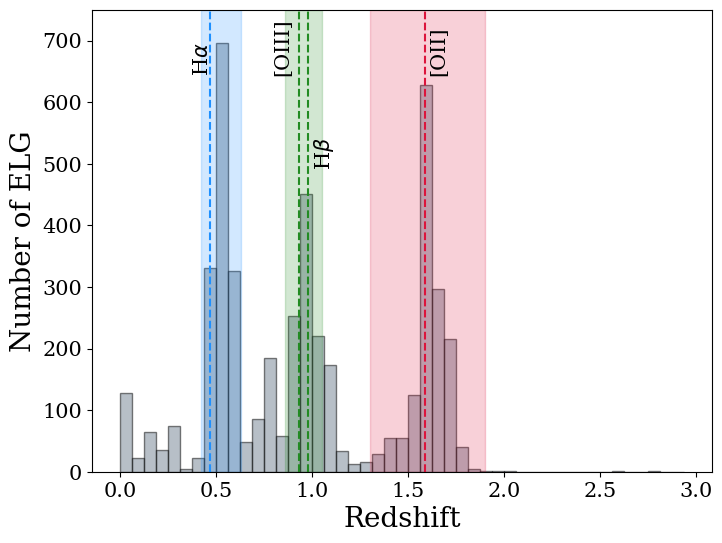

In [174]:
fig,ax=plt.subplots(figsize=(8,6), dpi=100)

bins = np.arange(0,3,0.0625)


ax.hist(table['Z_BEST'], bins =bins, histtype ='bar', alpha = 0.5, 
         color = 'slategray',ec = 'k')

ax.vlines(0.47,0,1000, linestyle ='dashed', color = 'dodgerblue')
ax.axvspan(0.42, 0.63, alpha=0.2, color='dodgerblue')
ax.text(0.38, 650, r'H$\alpha$', size = 15, rotation='vertical')

ax.vlines(0.98,0,1000, linestyle ='dashed', color = 'forestgreen')
#ax.axvspan(0.86,1.05, alpha=0.2, color='forestgreen')
ax.text(1, 500, r'H$\beta$', size = 15, rotation='vertical')

ax.vlines(0.93,0,1000, linestyle ='dashed', color = 'forestgreen')
ax.axvspan(0.86,1.05, alpha=0.2, color='forestgreen')
ax.text(0.8, 650, r'[OIII]', size = 15, rotation='vertical')

ax.vlines(1.59,0,1000, linestyle ='dashed', color = 'crimson')
ax.axvspan(1.3, 1.9, alpha=0.2, color='crimson')
ax.text(1.61, 650, r'[OII]', size = 15, rotation='vertical')

# ax.vlines(2.44,0,1000, linestyle ='dashed', color = 'crimson')
# ax.axvspan(1.30, 1.9, alpha=0.2, color='crimson')
# ax.text(2.5, 650, r'MgII', size = 15, rotation='vertical')

#plt.vlines(0.2,0,1000, linestyle ='dashed', color = 'crimson')
#ax.set_xlim(0,3)
ax.set_ylim(0,750)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of ELG')
plt.show()

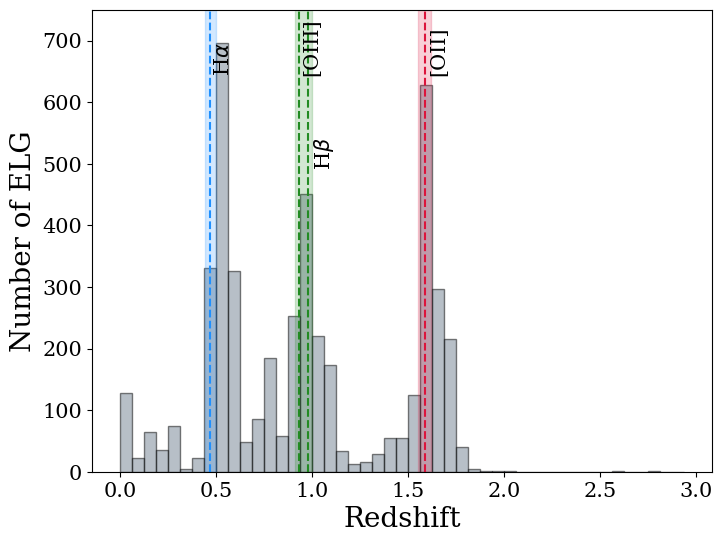

In [150]:
fig,ax=plt.subplots(figsize=(8,6), dpi=100)

bins = np.arange(0,3,0.0625)


ax.hist(table['Z_BEST'], bins =bins, histtype ='bar', alpha = 0.5, 
         color = 'slategray',ec = 'k')

ax.vlines(0.47,0,1000, linestyle ='dashed', color = 'dodgerblue')
ax.axvspan(0.44, 0.5, alpha=0.2, color='dodgerblue')
ax.text(0.49, 650, r'H$\alpha$', size = 15, rotation='vertical')

ax.vlines(0.98,0,1000, linestyle ='dashed', color = 'forestgreen')
#ax.axvspan(0.86,1.05, alpha=0.2, color='forestgreen')
ax.text(1, 500, r'H$\beta$', size = 15, rotation='vertical') 

ax.vlines(0.93,0,1000, linestyle ='dashed', color = 'forestgreen')
ax.axvspan(0.91,1.0, alpha=0.2, color='forestgreen')
ax.text(0.95, 650, r'[OIII]', size = 15, rotation='vertical')

ax.vlines(1.59,0,1000, linestyle ='dashed', color = 'crimson')
ax.axvspan(1.55, 1.62, alpha=0.2, color='crimson')
ax.text(1.61, 650, r'[OII]', size = 15, rotation='vertical')

# ax.vlines(2.44,0,1000, linestyle ='dashed', color = 'crimson')
# ax.axvspan(1.30, 1.9, alpha=0.2, color='crimson')
# ax.text(2.5, 650, r'MgII', size = 15, rotation='vertical')

#plt.vlines(0.2,0,1000, linestyle ='dashed', color = 'crimson')
#ax.set_xlim(0,3)
ax.set_ylim(0,750)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of ELG')
plt.show()

#  H-$\alpha$

In [151]:
pop =0.24237648

In [152]:
#mask1b = (0.42 < table['Z_BEST']) & (table['Z_BEST'] < 0.63)
mask1b = (0.42 < table2['Z_BEST']) & (table2['Z_BEST'] < 0.63)
H_a2 = table2[mask1b]

In [153]:
#mask1 =  (0.44 < table['Z_BEST']) & (table['Z_BEST'] < 0.55)
mask1 =  (0.42 < table['Z_BEST']) & (table['Z_BEST'] < 0.63)
H_a = table[mask1]

In [154]:
phi_star = 10**(-3.16) #* (u.Mpc ** -3)
L_star = (10**(41.72))
m_star = lum_mag(10**(41.72))
alpha = -1.75
model = Schechter1D(phi_star, m_star, alpha)

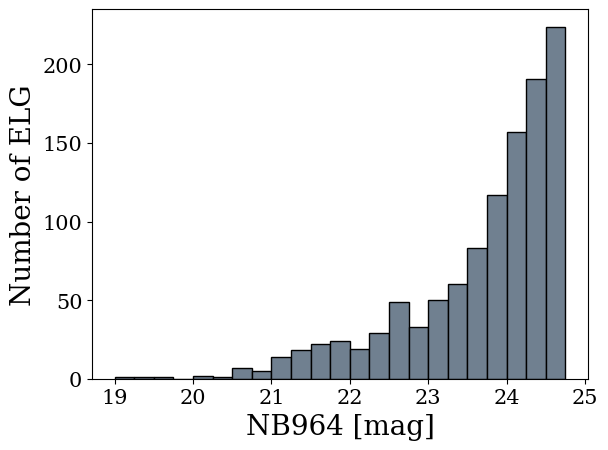

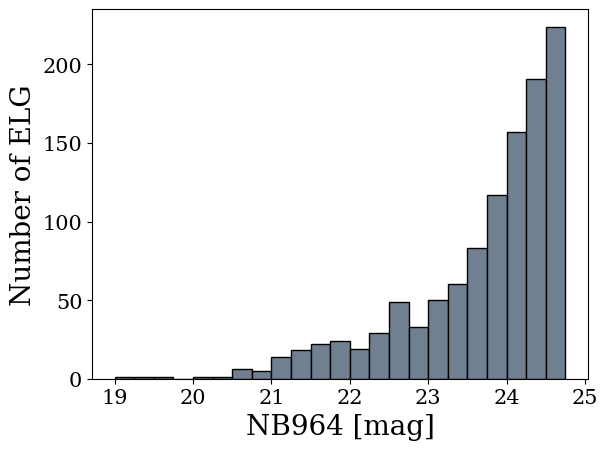

In [155]:
aper =2

NB_1 = np.array([H_a['MAG_APER_1'][i][aper] for i in range(len(H_a))]) +pop
NB_1b = np.array([H_a2['MAG_APER_1'][i][aper] for i in range(len(H_a2))])+pop 


bins1 = np.arange(19, 25, 0.25)
plt.hist(NB_1, bins = bins1 ,color = 'slategray',ec = 'k')
plt.xlabel('NB964 [mag]')
plt.ylabel('Number of ELG')
#plt.xlim(22,25)
plt.show()

plt.hist(NB_1b, bins = bins1 ,color = 'slategray',ec = 'k')
plt.xlabel('NB964 [mag]')
plt.ylabel('Number of ELG')
#plt.xlim(22,25)
plt.show()

In [156]:
a = lum_func(0.47, 2.94, NB_1)

Bines: 12
Bin 0: 2
Bin 1: 1
Bin 2: 5
Bin 3: 18
Bin 4: 32
Bin 5: 46
Bin 6: 54
Bin 7: 81
Bin 8: 119
Bin 9: 227
Bin 10: 337
Bin 11: 445


In [157]:
a[1]

[1.0468475589126202e-05,
 5.234237794563101e-06,
 2.6171188972815505e-05,
 9.421628030213583e-05,
 0.00016749560942601923,
 0.00024077493854990264,
 0.0002826488409064075,
 0.00042397326135961116,
 0.0006228742975530091,
 0.001188171979365824,
 0.0017639381367677651,
 0.00232923581858058]

In [158]:
a2 = lum_func(0.47, 2.94, NB_1b)

Bines: 12
Bin 0: 2
Bin 1: 1
Bin 2: 4
Bin 3: 17
Bin 4: 32
Bin 5: 46
Bin 6: 54
Bin 7: 81
Bin 8: 119
Bin 9: 227
Bin 10: 337
Bin 11: 445


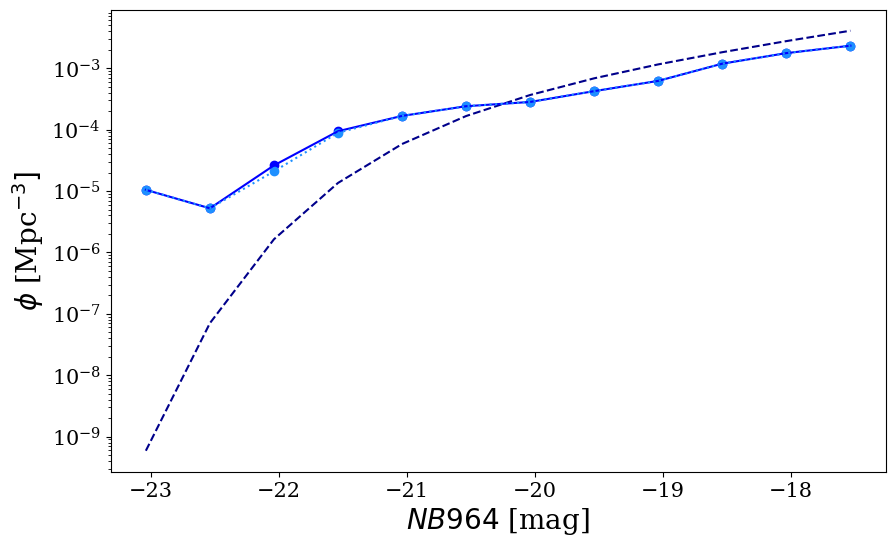

In [159]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(a[0], (model(a[0])), color = 'darkblue', linestyle = 'dashed')


ax.scatter(a[0], a[1], color = 'blue')
ax.plot(a[0], a[1], color = 'blue')

ax.scatter(a2[0], a2[1], color = 'dodgerblue')
ax.plot(a2[0], a2[1], color = 'dodgerblue', linestyle = 'dotted')


ax.set_yscale('log')
#ax.set_xlim(20, 30)
ax.set_xlabel('$NB964$ [mag]')
ax.set_ylabel('$\phi$ [Mpc$^{-3}]$')
plt.show()

In [160]:
NB_1c = np.array([H_a['FLUX_APER_1'][i][aper] for i in range(len(H_a))])
print(np.max(NB_1c))
mask_flux = NB_1c < 1000
NB_1f2 = NB_1c[mask_flux]
NB_1f = NB_1[mask_flux]
print(len(NB_1f))
a3 = flux_lum(0.47, 2.94, NB_1f2)

1893.5281
1364
Bines: 4
Bin 0: 959
Bin 1: 268
Bin 2: 111
Bin 3: 26


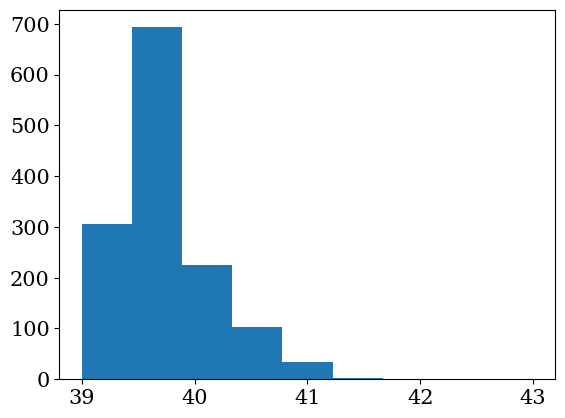

In [171]:
b = np.linspace(39, 43,10)
alf, blf, clf =plt.hist(a3[2], bins =b) #alf = objetos por bin
#plt.xlim(41,43.5)
plt.show()

In [162]:
bx = (b[0:-1]+b[1:])/2

In [163]:
binsize = bx[1]-bx[0]

lss = np.linspace(38,44,100)

#sch = schechter()

In [167]:
vol = volume_redshift(0.47,2.94)

numb_ =  np.logspace((38),(44),100)
phia = sch(phi_star, numb_, L_star, alpha, binsize)


phi_star_min = 10**(-3.16 -0.09) #* (u.Mpc ** -3)
L_star_min = (10**(41.72-0.09))
phi_min = sch(phi_star_min, numb_, L_star_min, alpha, binsize)


phi_star_max = 10**(-3.16 +0.09) #* (u.Mpc ** -3)
L_star_max = (10**(41.72 +0.09))
phi_max = sch(phi_star_max, numb_, L_star_max, alpha, binsize)

#phis, L, Ls, alpha, deltaL

sch_ = schechter(10**lss, alpha, phi_star, L_star)
#(L, alpha,phi, Ls):

In [168]:
alf

array([80., 66., 36., 38., 33., 22., 10.,  3.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.])

/tmp/ipykernel_724/3239814270.py:2: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(alf)
/tmp/ipykernel_724/3239814270.py:3: RuntimeWarning: invalid value encountered in multiply
  plt.errorbar(bx,yy, yerr = yy*err, ls = 'none', marker = 's', color = 'k' )


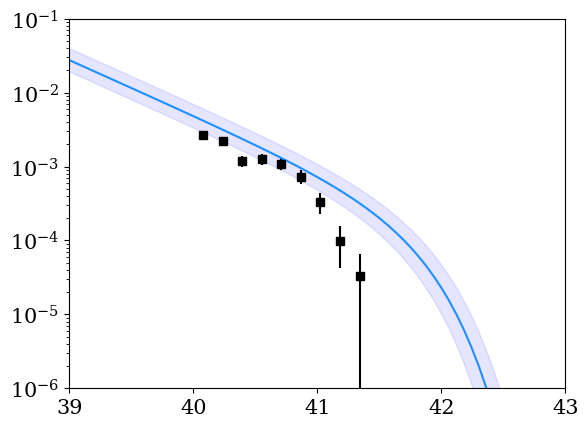

In [170]:
yy = alf/vol/binsize
err = 1/np.sqrt(alf)
plt.errorbar(bx,yy, yerr = yy*err, ls = 'none', marker = 's', color = 'k' )
plt.fill_between(lss, phi_min, phi_max, alpha = 0.1, color = 'blue')
plt.plot(lss, phia, color = 'dodgerblue')
plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(39,43)
plt.show()

In [29]:
a4 = lum_func(0.47, 2.94, NB_1f)

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(a[0], (model(a[0])), color = 'darkblue', linestyle = 'dashed')


ax.scatter(a[0], a[1], color = 'blue')
ax.plot(a[0], a[1], color = 'blue')

ax.scatter(a2[0], a2[1], color = 'dodgerblue')
ax.plot(a2[0], a2[1], color = 'dodgerblue', linestyle = 'dotted')


ax.set_yscale('log')
#ax.set_xlim(20, 30)
ax.set_xlabel('$NB964$ [mag]')
ax.set_ylabel('$\phi$ [Mpc$^{-3}]$')
plt.show()

In [31]:
# numb_ =  np.logspace((40),(44),100)
# phia = sch(phi_star, numb_, L_star, alpha, 0.5) #phis, L, Ls, alpha, deltaL

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

# ax.plot(a[0], (model(a[0])), color = 'darkblue', linestyle = 'dashed')


ax.plot(a3[0], a3[1], color = 'blue')
ax.scatter(a3[0], a3[1], color = 'blue')

# ax.plot(a3[0], a3[1], color = 'blue')
# ax.scatter(a3[0], a3[1], color = 'blue')

ax.plot(np.log10(numb_), phia, color = 'cyan')
#ax.scatter(np.log10(numb_), phia, color = 'red')

# ax.scatter(a2[0], a2[1], color = 'dodgerblue')
# ax.plot(a2[0], a2[1], color = 'dodgerblue', linestyle = 'dotted')

ax.set_yscale('log')
ax.set_xlim(41, 43)
ax.set_ylim(1e-10, 1e-1)
ax.set_xlabel(r'$log_{10}$ H-$\alpha$ Luminosity [erg $s^{-1}$]')
ax.set_ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3} dlog_{10} L]$')
plt.show()

In [33]:
# f1 = interp1d(a[0], a[1])

# lins1 = np.linspace(np.min(a[0]),np.max(a[0]),1000)

# rec1 = f1(lins1)

# popt1,pcov1 = curve_fit(func, lins1, rec1, p0 = (10**(-3.16),lum_mag(10**(41.72)), -1.75))

# model1b = Schechter1D(popt1[0], popt1[1], popt1[2])

# fig, ax = plt.subplots(figsize=(10, 6))

# ax.plot(a[0], (model(a[0])), color = 'darkblue', linestyle = 'dashed')
# #ax.plot(c[0], (model4(c[0])), color = 'darkviolet', linestyle = 'dashed')
# ax.scatter(a[0], a[1], color = 'blue')
# ax.plot(a[0], a[1], color = 'blue')
# ax.plot(lins1 ,func(lins1,*popt1), color = 'cyan')
# ax.set_yscale('log')
# ax.set_ylim(1e-7, 1e-1)
# #ax.set_xlim(20, 30)
# ax.set_xlabel('$NB964$ [mag]')
# ax.set_ylabel('$\phi$ [Mpc$^{-3}]$')
# plt.show()

In [34]:
# bins_1 = np.arange(-22, -17, 0.25)
# plt.hist(a[0] ,bins = bins_1,color = 'slategray',ec = 'k')
# #plt.xlim(22,25)
# plt.show()

In [35]:
#bins1 = np.arange(19, 25, 0.25)
plt.hist(a2[2] ,color = 'slategray',ec = 'k')
plt.xlabel('NB964 [mag]')
plt.ylabel('Number of ELG')
#plt.xlim(22,25)
plt.show()

# OIII

Z = 0.93

In [36]:
#mask2 =  (0.7 < table['Z_BEST']) & (table['Z_BEST'] < 1.1)
mask2 = (0.86 < table['Z_BEST'] ) & (table['Z_BEST'] < 1.05)
O_III = table[mask2]

In [37]:
#mask2b = (0.91 < table['Z_BEST'] ) & (table['Z_BEST'] < 1.0)
mask2b = (0.86 < table2['Z_BEST'] ) & (table2['Z_BEST'] < 1.05)
O_III2 = table2[mask2b]

In [38]:
phi_star2 = 10**(-2.16) * (u.Mpc ** -3)
l_star2 = 10**(41.38)
m_star2 = lum_mag(10**(41.38))
alpha2 = -1.60
model2 = Schechter1D(phi_star2, m_star2, alpha2)

In [39]:
NB_2 = np.array([O_III['MAG_APER_1'][i][aper] for i in range(len(O_III))]) +pop
NB_2b = np.array([O_III2['MAG_APER_1'][i][aper] for i in range(len(O_III2))]) +pop

bins2 = np.arange(20, 25, 0.25)
plt.hist(NB_2, bins =bins2, color = 'slategray',ec = 'k')
#plt.xlim(22,25)
plt.xlabel('NB964 [mag]')
plt.ylabel('Number of ELG')
#plt.xlim(22,25)
plt.show()

plt.hist(NB_2b, bins = bins1 ,color = 'slategray',ec = 'k')
plt.xlabel('NB964 [mag]')
plt.ylabel('Number of ELG')
#plt.xlim(22,25)
plt.show()

In [40]:
b = lum_func(0.93, 2.94, NB_2)

In [41]:
b2 = lum_func(0.93, 2.94, NB_2b)

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(b[0], (model2(b[0])), color = 'darkgreen', linestyle = 'dashed')

ax.scatter(b[0], b[1], color = 'forestgreen')
ax.plot(b[0], b[1], color = 'forestgreen')

ax.scatter(b2[0], b2[1], color = 'greenyellow')
ax.plot(b2[0], b2[1], color = 'greenyellow', linestyle = 'dotted')

ax.set_yscale('log')
ax.set_ylim(1e-7, 1e-2)
ax.set_xlabel('$NB964$ [mag]')
ax.set_ylabel('$\phi$ [Mpc$^{-3}]$')
plt.show()

In [43]:
# f2 = interp1d(b[0], b[1])

# lins2 = np.linspace(np.min(b[0]),np.max(b[0]),1000)

# rec2 = f2(lins2)

# popt2,pcov2 = curve_fit(func, lins2, rec2, p0 = (10**(-2.16),lum_mag(10**(41.38)), -1.60))

# model2b = Schechter1D(popt2[0], popt2[1], popt2[2])

# fig, ax = plt.subplots(figsize=(10, 6))

# ax.plot(b[0], (model2(b[0])), color = 'darkgreen', linestyle = 'dashed')
# #ax.plot(c[0], (model4(c[0])), color = 'darkviolet', linestyle = 'dashed')
# ax.scatter(b[0], b[1], color = 'forestgreen')
# ax.plot(b[0], b[1], color = 'forestgreen')
# ax.plot(lins2, func(lins2,*popt2), color = 'limegreen')
# ax.set_yscale('log')
# ax.set_ylim(1e-7, 1e-1)
# #ax.set_xlim(20, 30)
# ax.set_xlabel('$NB964$ [mag]')
# ax.set_ylabel('$\phi$ [Mpc$^{-3}]$')
# plt.show()

In [44]:
NB_2c = np.array([O_III['FLUX_APER_1'][i][aper] for i in range(len(O_III))])

print(np.max(NB_2c))
mask_flux2 = NB_2c > 100
NB_2f = NB_2[mask_flux2]
print(len(NB_1f))
b3 = flux_lum(0.93, 2.94, NB_2c)

In [45]:
b4 = lum_func(0.93, 2.94, NB_2f)

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(b[0], (model2(b[0])), color = 'forestgreen', linestyle = 'dashed')


ax.scatter(b[0], b[1], color = 'forestgreen')
ax.plot(b[0], b[1], color = 'forestgreen')

ax.scatter(b4[0], b4[1], color = 'lightgreen')
ax.plot(b4[0], b4[1], color = 'lightgreen')

# ax.scatter(a2[0], a2[1], color = 'dodgerblue')
# ax.plot(a2[0], a2[1], color = 'dodgerblue', linestyle = 'dotted')


ax.set_yscale('log')
#ax.set_xlim(20, 30)
ax.set_xlabel('$NB964$ [mag]')
ax.set_ylabel('$\phi$ [Mpc$^{-3}]$')
plt.show()

In [47]:
#numb_ =  np.logspace((40),(44),100)
phib = sch(phi_star2, numb_, l_star2, alpha2, 0.5) #phis, L, Ls, alpha, deltaL

fig, ax = plt.subplots(figsize=(10, 6))

# ax.plot(a[0], (model(a[0])), color = 'darkblue', linestyle = 'dashed')


ax.plot(b3[0], b3[1], color = 'yellowgreen')
ax.scatter(b3[0], b3[1], color = 'yellowgreen')

ax.plot(np.log10(numb_), phia, color = 'forestgreen')
#ax.scatter(np.log10(numb_), phia, color = 'red')

# ax.scatter(a2[0], a2[1], color = 'dodgerblue')
# ax.plot(a2[0], a2[1], color = 'dodgerblue', linestyle = 'dotted')

ax.set_yscale('log')
ax.set_xlim(40.5, 43)
ax.set_ylim(1e-6, 1e-3)
ax.set_xlabel(r'$log_{10}$ [OIII +  H$\beta$] Luminosity [erg $s^{-1}$]')
ax.set_ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3} dlog_{10} L]$')
plt.show()

# OII

In [48]:
#mask3 =  (1.3 < table['Z_BEST']) & (table['Z_BEST'] < 1.9)
mask3 = (1.5 < table['Z_BEST'] ) & (table['Z_BEST'] < 1.7)
O_II = table[mask3]

In [49]:
#mask3b = (1.55 < table['Z_BEST'] ) & (table['Z_BEST'] < 1.62)
mask3b = (1.5 < table2['Z_BEST'] ) & (table2['Z_BEST'] < 1.7)
O_II2 = table2[mask3b]

In [50]:
phi_star3 = 10**(-1.97) * (u.Mpc ** -3)
l_star3 =10**(41.66)
m_star3 = lum_mag(10**(41.66))
alpha3 = -1.30
model3 = Schechter1D(phi_star3, m_star3, alpha3)

In [51]:
NB_3= np.array([O_II['MAG_APER_1'][i][aper] for i in range(len(O_II))]) +pop
NB_3b= np.array([O_II2['MAG_APER_1'][i][aper] for i in range(len(O_II2))]) +pop
bins3 = np.arange(21, 25, 0.25)
plt.hist(NB_3, bins =bins3, color = 'slategray',ec = 'k')
#plt.xlim(22,25)
plt.xlabel('NB964 [mag]')
plt.ylabel('Number of ELG')
plt.show()

plt.hist(NB_3b, bins = bins1 ,color = 'slategray',ec = 'k')
plt.xlabel('NB964 [mag]')
plt.ylabel('Number of ELG')
#plt.xlim(22,25)
plt.show()

In [52]:
c = lum_func(1.59, 2.94, NB_3)

In [53]:
c2 = lum_func(1.59, 2.94, NB_3b)

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(c[0], (model3(c[0])), color = 'darkred', linestyle = 'dashed')

ax.scatter(c[0], c[1], color = 'red')
ax.plot(c[0], c[1], color = 'red')


ax.scatter(c2[0], c2[1], color = 'hotpink')
ax.plot(c2[0], c2[1], color = 'hotpink', linestyle ='dotted')

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e-3)
#ax.set_xlim(20, 30)
ax.set_xlabel('$NB964$ [mag]')
ax.set_ylabel('$\phi$ [Mpc$^{-3}]$')
plt.show()

In [55]:
# f3 = interp1d(c[0], c[1])

# lins3 = np.linspace(np.min(c[0]),np.max(c[0]),1000)

# rec3 = f3(lins3)

# popt3,pcov3 = curve_fit(func, lins3, rec3, p0 = (10**(-1.97),lum_mag(10**(41.66)),-1.30))

# model3b = Schechter1D(popt3[0], popt3[1], popt3[2])

# fig, ax = plt.subplots(figsize=(10, 6))

# ax.plot(c[0], (model3(c[0])), color = 'darkred', linestyle = 'dashed')
# #ax.plot(c[0], (model4(c[0])), color = 'darkviolet', linestyle = 'dashed')
# ax.scatter(c[0], c[1], color = 'red')
# ax.plot(c[0], c[1], color = 'red')
# ax.plot(lins3, func(lins3,*popt3), color = 'mediumvioletred')
# ax.set_yscale('log')
# ax.set_ylim(1e-7, 1e-1)
# #ax.set_xlim(20, 30)
# ax.set_xlabel('$NB964$ [mag]')
# ax.set_ylabel('$\phi$ [Mpc$^{-3}]$')
# plt.show()

In [56]:
NB_3c = np.array([O_II['FLUX_APER_1'][i][aper] for i in range(len(O_II))])
c3 = flux_lum(1.59, 2.94, NB_3c)

In [57]:
#numb_ =  np.logspace((40),(44),100)
phic = sch(phi_star3, numb_, l_star3, alpha3, 0.5) #phis, L, Ls, alpha, deltaL

fig, ax = plt.subplots(figsize=(10, 6))

# ax.plot(a[0], (model(a[0])), color = 'darkblue', linestyle = 'dashed')


ax.plot(c3[0], c3[1], color = 'red')
ax.scatter(c3[0], c3[1], color = 'red')

ax.plot(np.log10(numb_), phic, color = 'crimson', linestyle = 'dashed')
#ax.scatter(np.log10(numb_), phia, color = 'red')

# ax.scatter(a2[0], a2[1], color = 'dodgerblue')
# ax.plot(a2[0], a2[1], color = 'dodgerblue', linestyle = 'dotted')

ax.set_yscale('log')
ax.set_xlim(41.5, 43)
ax.set_ylim(1e-7, 1e-3)
ax.set_xlabel(r'$log_{10}$ [OII] Luminosity [erg $s^{-1}$]')
ax.set_ylabel(r'$log_{10}$ $\phi$ [Mpc$^{-3} dlog_{10} L]$')
plt.show()